In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix,csr_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = csr_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
#sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [3]:
# # 1) Compute column sums and counts of stored entries
# col_sums   = np.bincount(sparse_matrix.indices, weights=sparse_matrix.data, minlength=sparse_matrix.shape[1])
# col_counts = np.bincount(sparse_matrix.indices, minlength=sparse_matrix.shape[1])

# # 2) Compute column means, with NaN for empty columns
# col_means = col_sums / col_counts
# col_means[col_counts == 0] = np.nan

# # 3) Convert sparse_matrix.data to float64 for compatibility
# sparse_matrix.data = sparse_matrix.data.astype(np.float64)

# # 4) Subtract the column means from each stored entry, in place
# sparse_matrix.data -= col_means[sparse_matrix.indices]

In [4]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

  (4, 2)	80


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)
np.fill_diagonal(sparse_matrix, 0)  # Set diagonal to zero

In [6]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

[[0.         0.05124506 0.27243588 0.1296068  0.27745892]
 [0.05124506 0.         0.05905128 0.05030473 0.08138042]
 [0.27243588 0.05905128 0.         0.09861386 0.31927219]
 [0.1296068  0.05030473 0.09861386 0.         0.09513554]
 [0.27745892 0.08138042 0.31927219 0.09513554 0.        ]]


In [7]:
Number_neighbors = 50

In [8]:
import umap
reducer = umap.UMAP(metric='precomputed',n_jobs=-1,min_dist=0.1,n_neighbors=Number_neighbors)
mapper=reducer.fit(np.asarray(1 - sparse_matrix))
coords=reducer.transform(np.asarray(1 - sparse_matrix))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# Get the indices of the top 500 values for each row
top_500_indices = np.argsort(sparse_matrix, axis=1)[:, -Number_neighbors:]

In [10]:
# # Create a new matrix to store the data
filtered_matrix = np.zeros((top_500_indices.shape[0], top_500_indices.shape[1]))

# Populate the matrix with data from sparse_matrix
for row_idx in range(top_500_indices.shape[0]):
    filtered_matrix[row_idx] = sparse_matrix[row_idx, top_500_indices[row_idx]]  # Direct indexing for numpy.ndarray


In [11]:
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
namess=[]
idss=[]
i=0
for bgg_id in unique_items:   
    new_var = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]
    namee = new_var['name'].values[0]
    ide= new_var['id'].values[0]
    namess.append(namee)
    idss.append(ide)
    i=i+1

In [12]:
import igraph as ig

# Extract indices and distances from neigh
# indices, dist, _ = neigh
weightss = filtered_matrix

# Create an edge list with weights
edges = []
weights = []
for i, neighbors in enumerate(np.asarray(top_500_indices)):
    for j, neighbor in enumerate(neighbors):
        if i != neighbor:  # Avoid self-loops
            edges.append((i, neighbor))
            weights.append(weightss[i, j])

# Create the igraph graph
g = ig.Graph(edges=edges, edge_attrs={"weight": weights}, directed=False)
print(g.summary())


IGRAPH U-W- 15738 786900 -- 
+ attr: weight (e)


In [13]:

g.vs["label"] = namess
g.vs["id"] = idss
#Need to add 
#-size
#-rating
#-complexity
#-min_players
#-max_players
#-min_players_rec
#-max_players_rec
#-min_players_best
#-max_players_best
#-min_time
#-max_time



In [14]:
import leidenalg as la
# partition = g.community_leiden(objective_function="modularity", weights="weight")
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight',max_comm_size=500,seed=42)
communities = partition.membership
print(partition.modularity)

0.5112348514565157


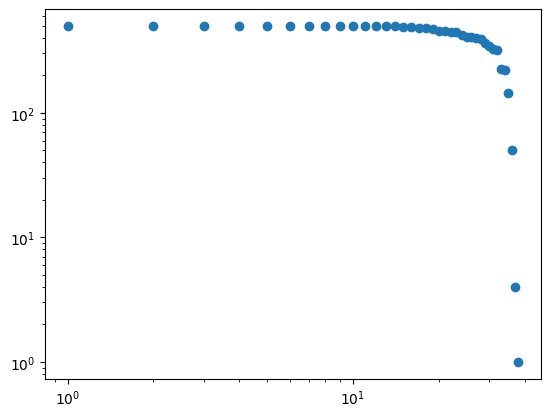

In [15]:
import matplotlib.pyplot as plt

unique_clusters, counts = np.unique(communities, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')


In [16]:
indices = [i for i, j in enumerate(communities) if j ==37]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.values[0])

Dale of Merchants
Dale of Merchants 2
Dale of Merchants Collection
Dale of Merchants 3


In [17]:
# for cluster, count in cluster_counts.items():
#     if count < 20:
#         cluster_indices = np.where(np.array(communities) == cluster)[0]
#         cluster_similarity = np.sum(sparse_matrix[cluster_indices, :], axis=0)
#         cluster_similarity[cluster_indices] = 0
#         target_cluster = communities[np.argmax(cluster_similarity)]
#         for idx in cluster_indices:
#             communities[idx] = target_cluster

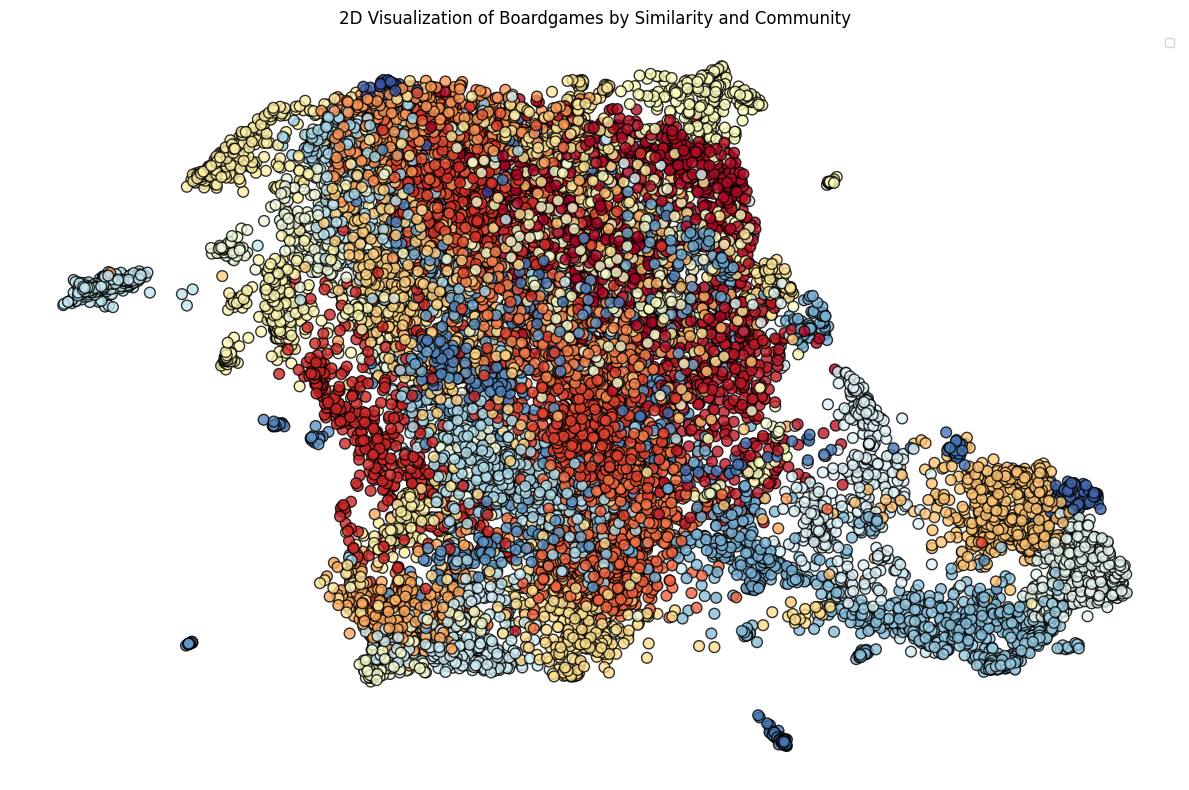

In [18]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))

plt.scatter(coords[:, 0], coords[:, 1],c=communities,cmap=plt.cm.RdYlBu ,s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()

/home/codespace/.python/current/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/codespace/.python/current/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warni

<AxesSubplot: >

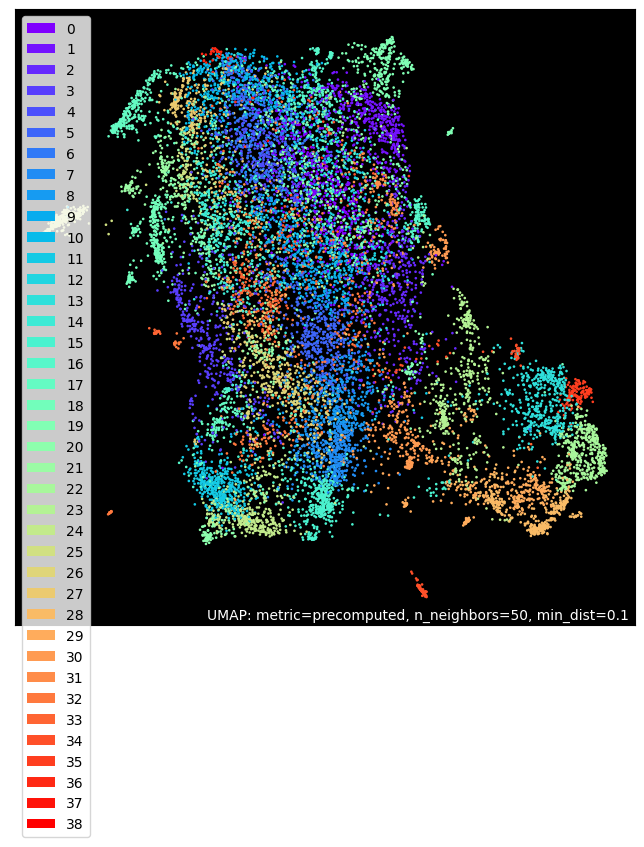

In [19]:
import umap.plot
import numpy as np

# Convert labels to a NumPy array
labels_array = np.array(communities)

# Plot the points
umap.plot.points(mapper, labels=labels_array, theme='fire')

In [20]:
indices = [i for i, j in enumerate(communities)]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
names=[]
ids=[]
i=0
for index in indices:    
    bgg_id = unique_items[index]
    new_var = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]
    name = new_var['name']
    id = new_var['id']
    ids.append(id.values[0])
    names.append(name.values[0])
    i=i+1
hover_data = pd.DataFrame({'Name':np.array(names),'Id':np.array(ids)})



In [21]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=labels_array, hover_data=hover_data, point_size=4,background='black')
umap.plot.show(p)

Loading BokehJS ...

In [22]:
# umap.plot.connectivity(mapper, edge_bundling='hammer')

In [23]:
# indices = [i for i, j in enumerate(communities) if j ==37]
# df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
# for index in indices:
#     bgg_id = unique_items[index]
#     name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
#     print(name.values[0])

In [24]:
# for cluster, count in cluster_counts.items():
#     if count < 20:
#         cluster_indices = np.where(np.array(communities) == cluster)[0]
#         cluster_similarity = np.sum(sparse_matrix[cluster_indices, :], axis=0)
#         cluster_similarity[cluster_indices] = 0
#         target_cluster = communities[np.argmax(cluster_similarity)]
#         #for idx in cluster_indices:
#             #communities[idx] = target_cluster

In [25]:
delete_graph_under_size = 20

In [26]:
clustered_graph =partition.cluster_graph("random","sum")
subgraphs = partition.subgraphs()

In [27]:
j = 0
dico = {}
indices_to_delete = []

for cluster, count in cluster_counts.items():
    j += 1
    if count < delete_graph_under_size:
        cluster_indices = np.where(np.array(communities) == cluster)[0]
        indices_to_delete.extend(cluster_indices.tolist())
        cluster_similarity = sparse_matrix[cluster_indices, :]

        row_idx, col_idx = np.unravel_index(np.argmax(cluster_similarity), cluster_similarity.shape)
        while col_idx in cluster_indices:
            cluster_similarity[row_idx, col_idx] = 0
            row_idx, col_idx = np.unravel_index(np.argmax(cluster_similarity), cluster_similarity.shape)
        row_idx = cluster_indices[row_idx]
        dico[row_idx] = (row_idx, col_idx, np.max(cluster_similarity))



In [28]:
# Map the IDs in indices_to_delete to the corresponding vertex indices in clustered_graph
ids_to_delete = set(indices_to_delete)
game_to_delete = [unique_items[id] for id in ids_to_delete]
vertex_indices_to_delete = [v.index for v in clustered_graph.vs if v["id"] in game_to_delete]
clustered_graph.delete_vertices(vertex_indices_to_delete)

In [29]:
for s, (source, target, weight) in dico.items():
    for idx, subgraph in enumerate(subgraphs):
        if unique_items[source] in subgraph.vs['id']:
            source_idx = idx     
        if unique_items[target] in subgraph.vs['id']:
            target_idx = idx
    merged_subgraph = subgraphs[source_idx] + subgraphs[target_idx]
    source_vertex  = merged_subgraph.vs.find(id=unique_items[source])
    target_vertex  = merged_subgraph.vs.find(id=unique_items[target])
    merged_subgraph.add_edge(source_vertex, target_vertex, weight=weight)
    subgraphs[target_idx]=merged_subgraph
   

In [ ]:
import netbone as nb
from netbone.filters import boolean_filter
def extract_backbone_preserve_indices2(subgraph):
    """
    Alternative version that maintains original vertex indices exactly
    by creating a sparse graph with the same index space
    """
    # Store original vertex attributes (excluding name and _nx_name)
    vertex_attrs = {}
    for v in subgraph.vs:
        attrs = dict(v.attributes())
        # Remove unwanted attributes
        attrs.pop('name', None)
        attrs.pop('_nx_name', None)
        vertex_attrs[v.index] = attrs
    
    # Store original edge attributes
    edge_attrs = {}
    for e in subgraph.es:
        edge_attrs[(e.source, e.target)] = dict(e.attributes())
        edge_attrs[(e.target, e.source)] = dict(e.attributes())
    
    # Convert to NetworkX
    G = subgraph.to_networkx()
    
    # Apply PMFG backbone extraction
    pmfg_backbone = nb.pmfg(G)
    pmfg_backbone = boolean_filter(pmfg_backbone)
    
    # Create new igraph with preserved indices
    surviving_nodes = list(pmfg_backbone.nodes())
    
    # Create vertex index mapping to preserve original indices
    node_mapping = {node: i for i, node in enumerate(sorted(surviving_nodes))}
    reverse_mapping = {i: node for node, i in node_mapping.items()}
    
    # Create new graph
    backbone_ig = ig.Graph(n=len(surviving_nodes))
    
    # Add edges
    edges_to_add = []
    for edge in pmfg_backbone.edges():
        source, target = edge
        new_source = node_mapping[source]
        new_target = node_mapping[target]
        edges_to_add.append((new_source, new_target))
    
    if edges_to_add:
        backbone_ig.add_edges(edges_to_add)
        
        # Set edge attributes
        for i, (new_source, new_target) in enumerate(edges_to_add):
            orig_source = reverse_mapping[new_source]
            orig_target = reverse_mapping[new_target]
            
            # Find original edge attributes
            edge_key = (orig_source, orig_target)
            if edge_key not in edge_attrs:
                edge_key = (orig_target, orig_source)
            
            if edge_key in edge_attrs:
                for attr_name, attr_value in edge_attrs[edge_key].items():
                    backbone_ig.es[i][attr_name] = attr_value
    
    # Set vertex attributes
    for new_idx, orig_idx in reverse_mapping.items():
        if orig_idx in vertex_attrs:
            for attr_name, attr_value in vertex_attrs[orig_idx].items():
                backbone_ig.vs[new_idx][attr_name] = attr_value
    
    return backbone_ig

def extract_backbone_preserve_indices(subgraph,idx):
    try:
        return extract_backbone_preserve_indices2(subgraph)
    except:
        print("Subgraph index errored:", idx) 
        return None
 

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
subgraphs_backbone = Parallel(n_jobs=-1)(
    delayed(extract_backbone_preserve_indices)(subgraph,idx) for idx,subgraph in enumerate(subgraphs)
)
clustered_graph_backbone = extract_backbone_preserve_indices(clustered_graph)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/home/codespace/.local/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-pa

Citation here


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min


Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.4min


Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here
Citation here


[Parallel(n_jobs=-1)]: Done  20 out of  39 | elapsed:  6.9min remaining:  6.6min


Citation here
Citation here
Citation here
Citation here


[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:  7.7min remaining:  4.8min


Citation here
Citation here
Citation here


NetworkXError: Invalid edge_attr argument: No columns found with name: []

In [ ]:
# clustered_graph_copy = clustered_graph.copy()

In [ ]:
# vertex_dataframe = clustered_graph_backbone.get_vertex_dataframe().to_dict()['_nx_name']

# i=0

In [ ]:
#clustered_graph_copy.delete_edges([(1,2), (2,3)])  # Example of removing edges

In [ ]:

# clustered_graph_backbone.write_dot("../graph/clustered_graph_backbone.dot")
# clustered_graph.write_dot("../graph/clustered_graph.dot")

In [81]:
import os
import glob

files = glob.glob("../graph/*")
for f in files:
    os.remove(f)

In [ ]:
i=0
clustered_graph_backbone.write_dot("../graph/clustered_graph.dot")
for subgraph in subgraphs_backbone:
    if(len(subgraph.vs) < delete_graph_under_size):
        continue
    subgraph.write_dot(f"../graph/subgraph_{i}.dot")
    i+=1